<a href="https://colab.research.google.com/github/Andreaw2/GA-Projs/blob/main/Capstone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signature Forgery Detection

## Despite widespread digitalisation in the financial industry, there are still certain transactions that require the use of signatures as a primary way of authenticating a transaction. Signing cheques, authorising documents and contracts, approving purchases are some business activities that usually require signatures. 

## How are we able to navigate the risks involved with signature forgery? Especially if the signatures are use as authentication for high-valued transactions. Manual signature verification methods are also generally dependent on humna factors and may be prone to errors including expertise or mood. 


## In this capstone, I will be exploring the use of neural networks in classifying whether a signature is genuine or forged. The focus of this project would be on offline handwritten signatures. The goal of the project is to limit both type I and Type II errors. Type I error refer to mistakenly identifying a genuine signature wrongly, leading to a negative impact on customer satisfaction. Type II error refers to wrongly identifying a forged signature, leading to financial loss and a negative impact on reputation as well. 


# Data Collection 

## Train and test dataset of genuine and forgery signatures from various individuals have been collected from Kaggle. The dataset was extracted from ICDAR 2011 Signature Dataset containing signatures from dutch users. 

In [ ]:
import os
import glob
import datetime
import re
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.losses import Loss
from keras_preprocessing import image
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

In [ ]:
! pip install -q kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download 'robinreni/signature-verification-dataset/versions/2?resource=download' -p sign --unzip

 97% 585M/601M [00:04<00:00, 153MB/s]
100% 601M/601M [00:04<00:00, 141MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sign


In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
os.listdir() #list directories and files 

['.config', 'kaggle.json', 'sign', 'sample_data']

In [ ]:
col_name = ['image1','image2','label']
df_train=pd.read_csv('/content/sign/sign_data/train_data.csv', names = col_name)
df_train.sample(10)

,image1,image2,label
14855,016/016_05.PNG,016/016_03.PNG,0
14645,016/016_16.PNG,016_forg/0202016_03.png,1
17,068/11_068.png,068_forg/01_0124068.PNG,1
3084,058/11_058.png,058_forg/02_0125058.PNG,1
9650,006/006_19.PNG,006/006_07.PNG,0
833,047/01_047.png,047_forg/03_0212047.PNG,1
21320,059/02_059.png,059/11_059.png,0
12229,050/08_050.png,050/03_050.png,0
11886,046/04_046.png,046_forg/03_0123046.PNG,1
14925,016/016_09.PNG,016/016_02.PNG,0


In [ ]:
base_dir = '/content/sign/sign_data/'

test_dir = os.path.join(base_dir, 'test')
test_csv = os.path.join(base_dir, 'test_data.csv')


train_dir = os.path.join(base_dir, 'train')
train_csv = os.path.join(base_dir, 'train_data.csv')

#Train Directory


In [ ]:
filelist = [file for file in os.listdir(train_dir)]

print(f"There are {len(filelist)} subfolders in train directory")


There are 128 subfolders in train directory


In [ ]:
subdir = []  ### filepath of each sub directory
for x in filelist:
  image_path = os.path.join(train_dir, x)
  subdir.append(image_path)


In [ ]:
sig_ind_train_genuine = []
sig_ind_train_forge = []
for x in subdir:
  p=Path(x)
  if "forg" not in x:
    sig_ind_train_genuine.append(p.parts[5])
  else:
    sig_ind_train_forge.append(p.parts[5])

print(f"There are genuine signatures of {len(sig_ind_train_genuine)} individuals in the train dataset")
print(f"There are forged signatures of {len(sig_ind_train_forge)} individuals in the train dataset")

There are genuine signatures of 64 individuals in the train dataset
There are forged signatures of 64 individuals in the train dataset


###There are signatures from 64 individuals in the train dataset. Each individual is assigned a number, starting from 001 to 069. Some individuals are not included in the training dataset - 005, 007, 008, 010, 011.


### Each individual has two folders, one folder with genuine signatures and another folder with forgery signatures, adding up to 128 subfolders in the train directory.

In [ ]:
png_count = 0 ##count of png images in train directory
pngfnames = []


for x in subdir:
  path = os.listdir(x)
  png_count += len(path)

print(png_count)

1649


In [ ]:
png = 0  # total files
for dirpath, dirnames, filenames in os.walk(train_dir):
    pngpath = []
    N_c = len(filenames)
    png += N_c

    
    pngpath.append(filenames)
    print ("File path:", dirpath, "no of png images:", N_c)
print ("Total png files in train directory",png)

File path: /content/sign/sign_data/train no of png images: 0
File path: /content/sign/sign_data/train/032 no of png images: 12
File path: /content/sign/sign_data/train/003_forg no of png images: 12
File path: /content/sign/sign_data/train/060_forg no of png images: 12
File path: /content/sign/sign_data/train/062 no of png images: 12
File path: /content/sign/sign_data/train/058 no of png images: 12
File path: /content/sign/sign_data/train/030_forg no of png images: 12
File path: /content/sign/sign_data/train/055_forg no of png images: 12
File path: /content/sign/sign_data/train/009_forg no of png images: 12
File path: /content/sign/sign_data/train/053 no of png images: 12
File path: /content/sign/sign_data/train/012 no of png images: 24
File path: /content/sign/sign_data/train/036 no of png images: 12
File path: /content/sign/sign_data/train/061_forg no of png images: 12
File path: /content/sign/sign_data/train/001_forg no of png images: 8
File path: /content/sign/sign_data/train/040_fo

###There are 1649 images in the 128 subfolders within the train directory

#Sample Images - Train Directory

In [ ]:
train_file_name = []
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        train_file_name.append(os.path.join(path, name))
train_file_name.sort()

In [ ]:
subplott = train_file_name[12:37]

In [ ]:
subplot_xlabels = []

for x in subplott:
  p = Path(x)
  subplot_xlabels.append(p.parts[5:7])

In [ ]:
train_images = []
for x in train_file_name:
  train_images.append(mpimg.imread(x))

In [ ]:
train_images_subplot = train_images[12:37]

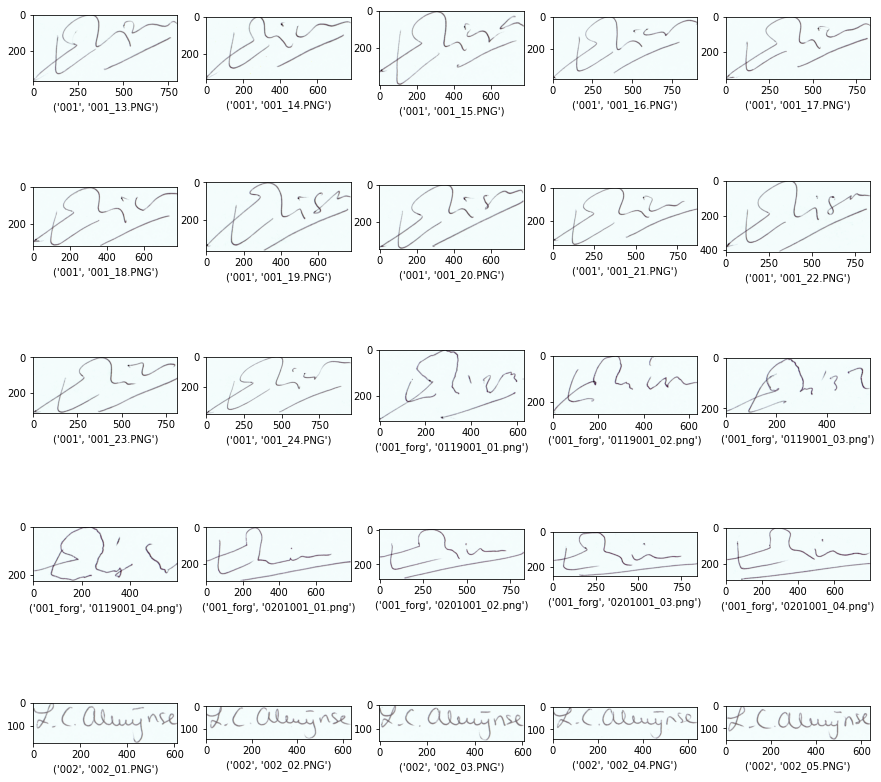

In [ ]:
plt.figure(figsize=(15,15)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(train_images_subplot[i])
    plt.xlabel(subplot_xlabels[i])

plt.show()

### indiv, forged and genuine signature breakdown 

In [ ]:
subdir.sort() 
subdir[:10]

['/content/sign/sign_data/train/001',
 '/content/sign/sign_data/train/001_forg',
 '/content/sign/sign_data/train/002',
 '/content/sign/sign_data/train/002_forg',
 '/content/sign/sign_data/train/003',
 '/content/sign/sign_data/train/003_forg',
 '/content/sign/sign_data/train/004',
 '/content/sign/sign_data/train/004_forg',
 '/content/sign/sign_data/train/006',
 '/content/sign/sign_data/train/006_forg']

In [ ]:
train_file_name = []
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        train_file_name.append(os.path.join(path, name))


In [ ]:
train_file_name.sort()
train_file_name[:10]

['/content/sign/sign_data/train/001/001_01.PNG',
 '/content/sign/sign_data/train/001/001_02.PNG',
 '/content/sign/sign_data/train/001/001_03.PNG',
 '/content/sign/sign_data/train/001/001_04.PNG',
 '/content/sign/sign_data/train/001/001_05.PNG',
 '/content/sign/sign_data/train/001/001_06.PNG',
 '/content/sign/sign_data/train/001/001_07.PNG',
 '/content/sign/sign_data/train/001/001_08.PNG',
 '/content/sign/sign_data/train/001/001_09.PNG',
 '/content/sign/sign_data/train/001/001_10.PNG']

In [ ]:
individual = []
for x in train_file_name:
  p=Path(x)
  


In [ ]:
p=Path(train_file_name[1])
p

PosixPath('/content/sign/sign_data/train/001/001_02.PNG')

In [ ]:
p.parts[5]

'001'

In [ ]:
individuals_id_gen = []
individuals_id_forge = []
forge_counts = []
gen_counts = []
for x in train_file_name:
  p=Path(x)
  if 'forg' in x:
    new_x = re.sub('\D', '', p.parts[5])
    individuals_id_forge.append(new_x)

    forge_counts.append(p.parts[6])
  else:
    individuals_id_gen.append(p.parts[5])

    gen_counts.append(p.parts[6])

In [ ]:
len((individuals_id_gen))

887

In [ ]:
len((gen_counts))

887

In [ ]:
df_genuine = pd.DataFrame()

In [ ]:
df_genuine['indiv_id'] = individuals_id_gen

In [ ]:
df_genuine['file_name'] = gen_counts

In [ ]:
df_genuine['genuine'] = 1

In [ ]:
df_genuine.head()


,indiv_id,file_name,genuine
0,001,001_01.PNG,1
1,001,001_02.PNG,1
2,001,001_03.PNG,1
3,001,001_04.PNG,1
4,001,001_05.PNG,1


In [ ]:
df_forgery = pd.DataFrame()

In [ ]:
df_forgery['indiv_id'] = individuals_id_forge

In [ ]:
df_forgery['file_name'] = forge_counts

In [ ]:
df_forgery['genuine'] = 0

In [ ]:
df_genuine_updated = df_genuine.drop(['file_name'], axis = 1)

In [ ]:
df_genuine_updated.head()

,indiv_id,genuine
0,001,1
1,001,1
2,001,1
3,001,1
4,001,1


In [ ]:
df_genuine_updated["indiv_id"].value_counts().sort_index()

001    24
002    24
003    24
004    24
006    24
       ..
065    12
066    12
067    12
068    12
069    12
Name: indiv_id, Length: 64, dtype: int64

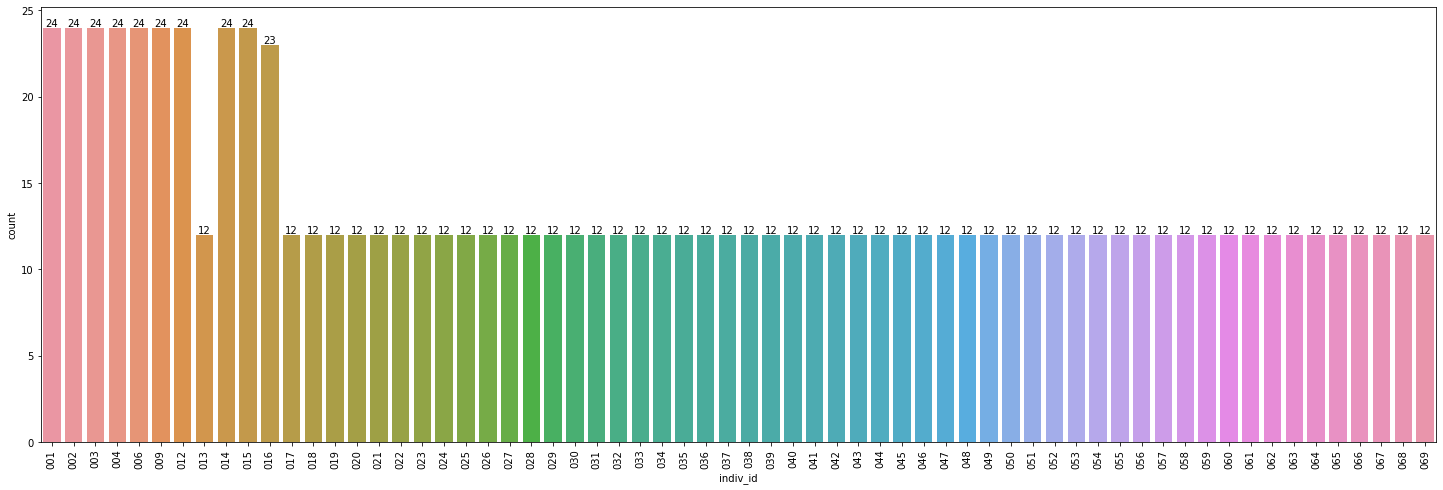

In [ ]:
plt.figure(figsize=(25,8))
ax = sns.countplot(x ="indiv_id", data = df_genuine_updated)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        df_genuine_updated["indiv_id"].value_counts().sort_index()[i],ha="center")
    i += 1

In [ ]:
df_forgery_updated = df_forgery.drop(['file_name'], axis = 1)

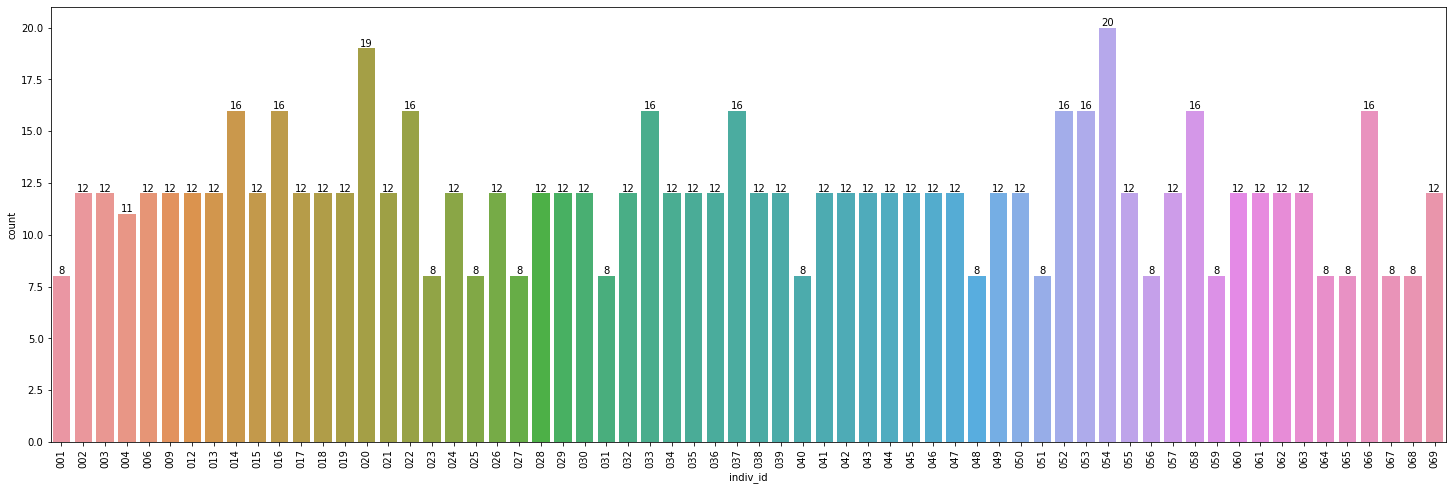

In [ ]:
plt.figure(figsize=(25,8))
ax = sns.countplot(x ="indiv_id", data = df_forgery_updated)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        df_forgery_updated["indiv_id"].value_counts().sort_index()[i],ha="center")
    i += 1

In [ ]:
individuals_id_join = []
genuine_counts = []
for x in train_file_name:
  p=Path(x)
  if 'forg' in x:
    new_x = re.sub('\D', '', p.parts[5])
    individuals_id_join.append(new_x)

    genuine_counts.append(0)
  else:
    individuals_id_join.append(p.parts[5])

    genuine_counts.append(1)

In [ ]:
df = pd.DataFrame()

In [ ]:
df['indiv_id'] = individuals_id_join
df['genuine_counts'] = genuine_counts

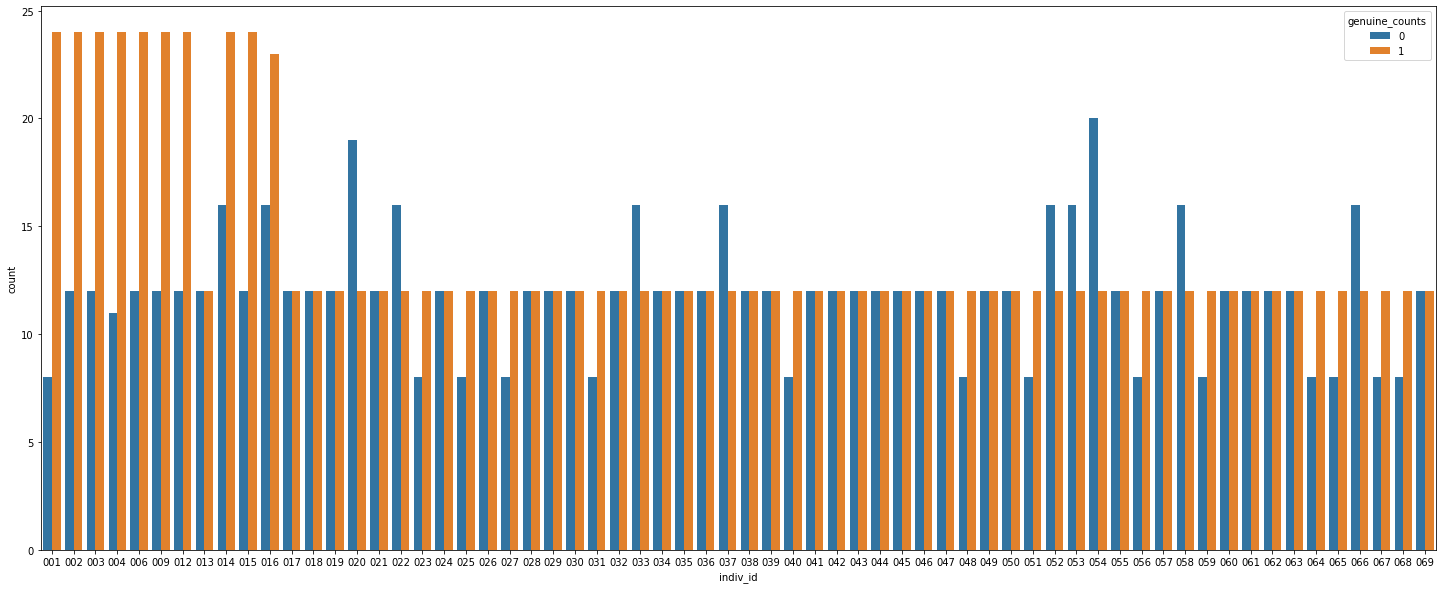

In [ ]:
plt.figure(figsize=(25,10))
ax = sns.countplot(x ="indiv_id", data = df, hue = 'genuine_counts')



#The number of genuine signatures and forgery signatures per individual are not identical. Only 32 individuals have the same number of genuine signatures and forgery signatures.

#Exploring train csv file

Siamese network can be used to predict the similarity between two image pairs and, more specifically, whether the two input images belong to the same or different classes.The csv file was mapped in a way in which each signature from each individual was match against other signatures from the same individual (genuine + forgery). For example if individual 001 has 10 signatures in the training file, 5 genuine, 5 forgery. each signature  will be mapped 9 times with the other 9 signatures.  

In [ ]:
colnames=['Image1', 'Image2', 'genuine'] 
df_train = pd.read_csv(train_csv, names =colnames, header=None)

In [ ]:
df_train.head()

,Image1,Image2,genuine
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [ ]:
df_train.shape

(23206, 3)

In [ ]:
sig1 = df_genuine_updated["indiv_id"].value_counts().sort_index().rename_axis('id').reset_index(name='genuine_counts') #gencounts
print (sig1)

     id  genuine_counts
0   001              24
1   002              24
2   003              24
3   004              24
4   006              24
..  ...             ...
59  065              12
60  066              12
61  067              12
62  068              12
63  069              12

[64 rows x 2 columns]


In [ ]:
sig2 = df["indiv_id"].value_counts().sort_index().rename_axis('id2').reset_index(name='total_counts')#totalcounts
print (sig2)

    id2  total_counts
0   001            32
1   002            36
2   003            36
3   004            35
4   006            36
..  ...           ...
59  065            20
60  066            28
61  067            20
62  068            20
63  069            24

[64 rows x 2 columns]


In [ ]:
sig_csvcounts = pd.concat([sig1,sig2], axis=1)
sig_csvcounts

,id,genuine_counts,id2,total_counts
0,001,24,001,32
1,002,24,002,36
2,003,24,003,36
3,004,24,004,35
4,006,24,006,36
...,...,...,...,...
59,065,12,065,20
60,066,12,066,28
61,067,12,067,20
62,068,12,068,20


In [ ]:
sig_csvcounts.drop("id2", axis=1, inplace=True) 

In [ ]:
sig_csvcounts['csvtotalrows'] = sig_csvcounts['genuine_counts'] *(sig_csvcounts['total_counts'] - 1)
sig_csvcounts

,id,genuine_counts,total_counts,csvtotalrows
0,001,24,32,744
1,002,24,36,840
2,003,24,36,840
3,004,24,35,816
4,006,24,36,840
...,...,...,...,...
59,065,12,20,228
60,066,12,28,324
61,067,12,20,228
62,068,12,20,228


In [ ]:
sig_csvcounts['csvtotalrows'].sum() ##total sum adds up to the number of rows in the csv file.

23206

#example individual 001

In [ ]:
id001 = df_train[df_train['Image1'].str.contains("001/")]
id001

,Image1,Image2,genuine
8412,001/001_04.PNG,001_forg/0119001_03.png,1
8413,001/001_04.PNG,001_forg/0201001_04.png,1
8414,001/001_04.PNG,001_forg/0201001_02.png,1
8415,001/001_04.PNG,001_forg/0119001_01.png,1
8416,001/001_04.PNG,001_forg/0201001_01.png,1
...,...,...,...
9151,001/001_07.PNG,001/001_13.PNG,0
9152,001/001_07.PNG,001/001_10.PNG,0
9153,001/001_07.PNG,001/001_03.PNG,0
9154,001/001_07.PNG,001/001_18.PNG,0


In [ ]:
id001['Image1'].value_counts() ## each genuine signature image from 001 appeared 31 times in the csv file, which shows that each signature image was mapped with every signature by 001 including forgery

001/001_04.PNG    31
001/001_09.PNG    31
001/001_24.PNG    31
001/001_18.PNG    31
001/001_03.PNG    31
001/001_10.PNG    31
001/001_13.PNG    31
001/001_17.PNG    31
001/001_23.PNG    31
001/001_01.PNG    31
001/001_20.PNG    31
001/001_15.PNG    31
001/001_21.PNG    31
001/001_02.PNG    31
001/001_06.PNG    31
001/001_22.PNG    31
001/001_19.PNG    31
001/001_05.PNG    31
001/001_08.PNG    31
001/001_16.PNG    31
001/001_14.PNG    31
001/001_12.PNG    31
001/001_11.PNG    31
001/001_07.PNG    31
Name: Image1, dtype: int64

In [ ]:
24*31  #each of the 24 genuine signatures by individual 001 were mapped against every other signature by individual 001

744

In [ ]:
compid = sig_csvcounts.loc[sig_csvcounts['id'] == '001']
compid

,id,genuine_counts,total_counts,csvtotalrows
0,001,24,32,744


#Test Directory

In [ ]:
filelist = [file for file in os.listdir(test_dir)]

print(f"There are {len(filelist)} subfolders in test directory")


There are 42 subfolders in test directory


In [ ]:
subdir_test = []  ### filepath of each sub directory
for x in filelist:
  image_path = os.path.join(test_dir, x)
  subdir_test.append(image_path)


In [ ]:
sig_ind_test_genuine = []
sig_ind_test_forge = []
for x in subdir_test:
  p=Path(x)
  if "forg" not in x:
    sig_ind_test_genuine.append(p.parts[5])
  else:
    sig_ind_test_forge.append(p.parts[5])

print(f"There are genuine signatures of {len(sig_ind_test_genuine)} individuals in the test dataset")
print(f"There are forged signatures of {len(sig_ind_test_forge)} individuals in the test dataset")

There are genuine signatures of 21 individuals in the test dataset
There are forged signatures of 21 individuals in the test dataset


#There are signatures from 21 individuals in the test dataset. 
#Each individual has two folders, one folder with genuine signatures and another folder with forgery signatures, adding up to 42 subfolders in the train directory.

In [ ]:
png = 0  # total files
for dirpath, dirnames, filenames in os.walk(test_dir):
    pngpath = []
    N_c = len(filenames)
    png += N_c

    
    pngpath.append(filenames)
    print ("File path:", dirpath, "no of png images:", N_c)
print ("Total png files in test directory",png)

File path: /content/sign/sign_data/test no of png images: 0
File path: /content/sign/sign_data/test/060_forg no of png images: 12
File path: /content/sign/sign_data/test/062 no of png images: 12
File path: /content/sign/sign_data/test/058 no of png images: 12
File path: /content/sign/sign_data/test/055_forg no of png images: 12
File path: /content/sign/sign_data/test/053 no of png images: 12
File path: /content/sign/sign_data/test/061_forg no of png images: 12
File path: /content/sign/sign_data/test/052 no of png images: 12
File path: /content/sign/sign_data/test/057 no of png images: 12
File path: /content/sign/sign_data/test/054_forg no of png images: 20
File path: /content/sign/sign_data/test/059 no of png images: 12
File path: /content/sign/sign_data/test/053_forg no of png images: 16
File path: /content/sign/sign_data/test/063_forg no of png images: 12
File path: /content/sign/sign_data/test/065 no of png images: 12
File path: /content/sign/sign_data/test/060 no of png images: 12


###There are 500 images in the 42 subfolders within the test directory

In [ ]:
test_file_name = []
for path, subdirs, files in os.walk(test_dir):
    for name in files:
        test_file_name.append(os.path.join(path, name))

In [ ]:
test_file_name.sort()
test_file_name[:10]

['/content/sign/sign_data/test/049/01_049.png',
 '/content/sign/sign_data/test/049/02_049.png',
 '/content/sign/sign_data/test/049/03_049.png',
 '/content/sign/sign_data/test/049/04_049.png',
 '/content/sign/sign_data/test/049/05_049.png',
 '/content/sign/sign_data/test/049/06_049.png',
 '/content/sign/sign_data/test/049/07_049.png',
 '/content/sign/sign_data/test/049/08_049.png',
 '/content/sign/sign_data/test/049/09_049.png',
 '/content/sign/sign_data/test/049/10_049.png']

In [ ]:
p=Path(test_file_name[1])
p

PosixPath('/content/sign/sign_data/test/049/02_049.png')

In [ ]:
p.parts[5]

'049'

In [ ]:
individuals_id_gen_test = []
individuals_id_forge_test = []
forge_counts = []
gen_counts = []
for x in test_file_name:
  p=Path(x)
  if 'forg' in x:
    new_x = re.sub('\D', '', p.parts[5])
    individuals_id_forge_test.append(new_x)

    forge_counts.append(p.parts[6])
  else:
    individuals_id_gen_test.append(p.parts[5])

    gen_counts.append(p.parts[6])

In [ ]:
len((individuals_id_gen_test))

252

In [ ]:
len((gen_counts))

252

In [ ]:
df_genuine_test = pd.DataFrame()

In [ ]:
df_genuine_test['indiv_id'] = individuals_id_gen_test

In [ ]:
df_genuine_test['file_name'] = gen_counts

In [ ]:
df_genuine_test['genuine'] = 1

In [ ]:
df_genuine_test.head()


,indiv_id,file_name,genuine
0,049,01_049.png,1
1,049,02_049.png,1
2,049,03_049.png,1
3,049,04_049.png,1
4,049,05_049.png,1


In [ ]:
df_forgery_test = pd.DataFrame()

In [ ]:
df_forgery_test['indiv_id'] = individuals_id_forge_test

In [ ]:
df_forgery_test['file_name'] = forge_counts

In [ ]:
df_forgery_test['genuine'] = 0

In [ ]:
df_genuine_updatedt = df_genuine_test.drop(['file_name'], axis = 1)

In [ ]:
df_genuine_updatedt.head()

,indiv_id,genuine
0,049,1
1,049,1
2,049,1
3,049,1
4,049,1


In [ ]:
df_genuine_updatedt["indiv_id"].value_counts().sort_index()

049    12
050    12
051    12
052    12
053    12
054    12
055    12
056    12
057    12
058    12
059    12
060    12
061    12
062    12
063    12
064    12
065    12
066    12
067    12
068    12
069    12
Name: indiv_id, dtype: int64

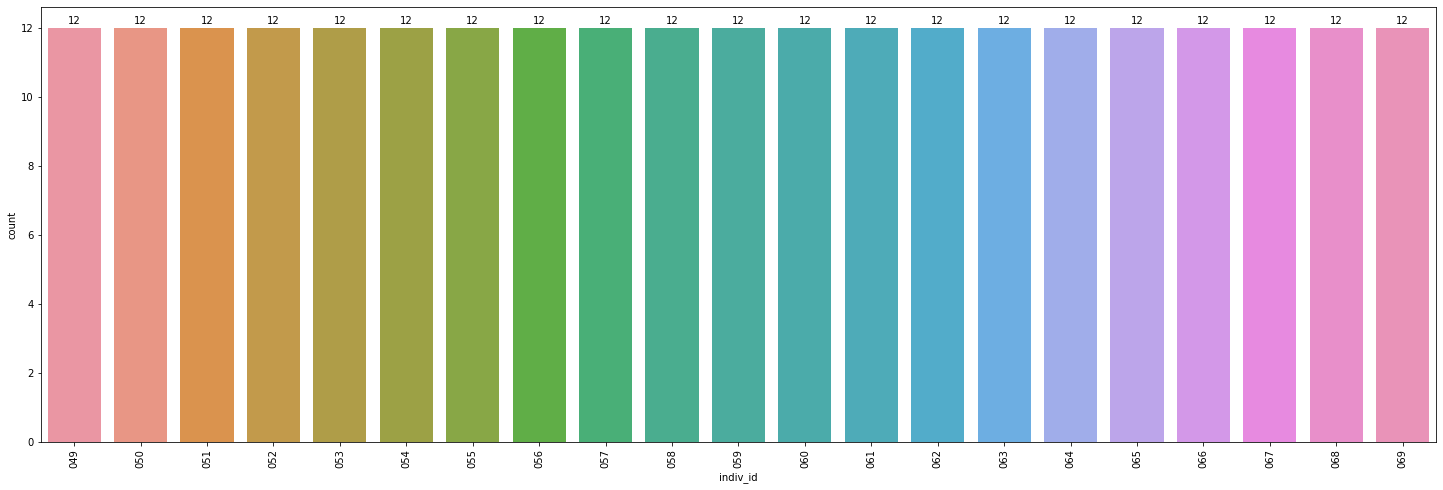

In [ ]:
plt.figure(figsize=(25,8))
ax = sns.countplot(x ="indiv_id", data = df_genuine_updatedt)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        df_genuine_updatedt["indiv_id"].value_counts().sort_index()[i],ha="center")
    i += 1

In [ ]:
df_forgery_updatedt = df_forgery_test.drop(['file_name'], axis = 1)

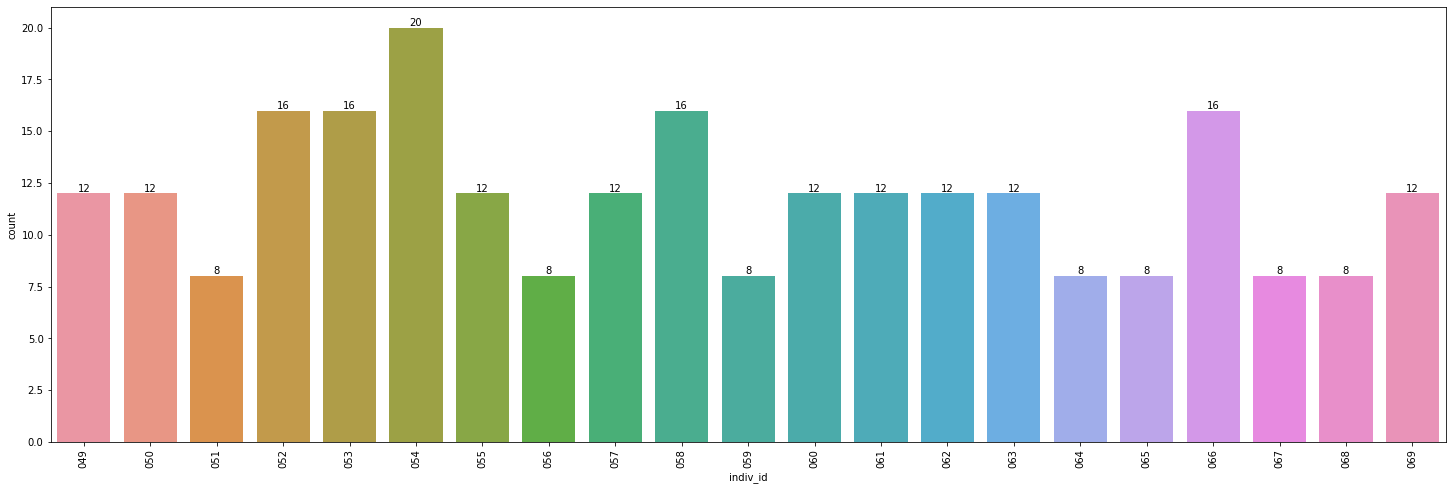

In [ ]:
plt.figure(figsize=(25,8))
ax = sns.countplot(x ="indiv_id", data = df_forgery_updatedt)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        df_forgery_updatedt["indiv_id"].value_counts().sort_index()[i],ha="center")
    i += 1

In [ ]:
individuals_id_joint = []
genuine_counts = []
for x in test_file_name:
  p=Path(x)
  if 'forg' in x:
    new_x = re.sub('\D', '', p.parts[5])
    individuals_id_joint.append(new_x)

    genuine_counts.append(0)
  else:
    individuals_id_joint.append(p.parts[5])

    genuine_counts.append(1)

In [ ]:
dft = pd.DataFrame()

In [ ]:
dft['indiv_id'] = individuals_id_joint
dft['genuine_counts'] = genuine_counts

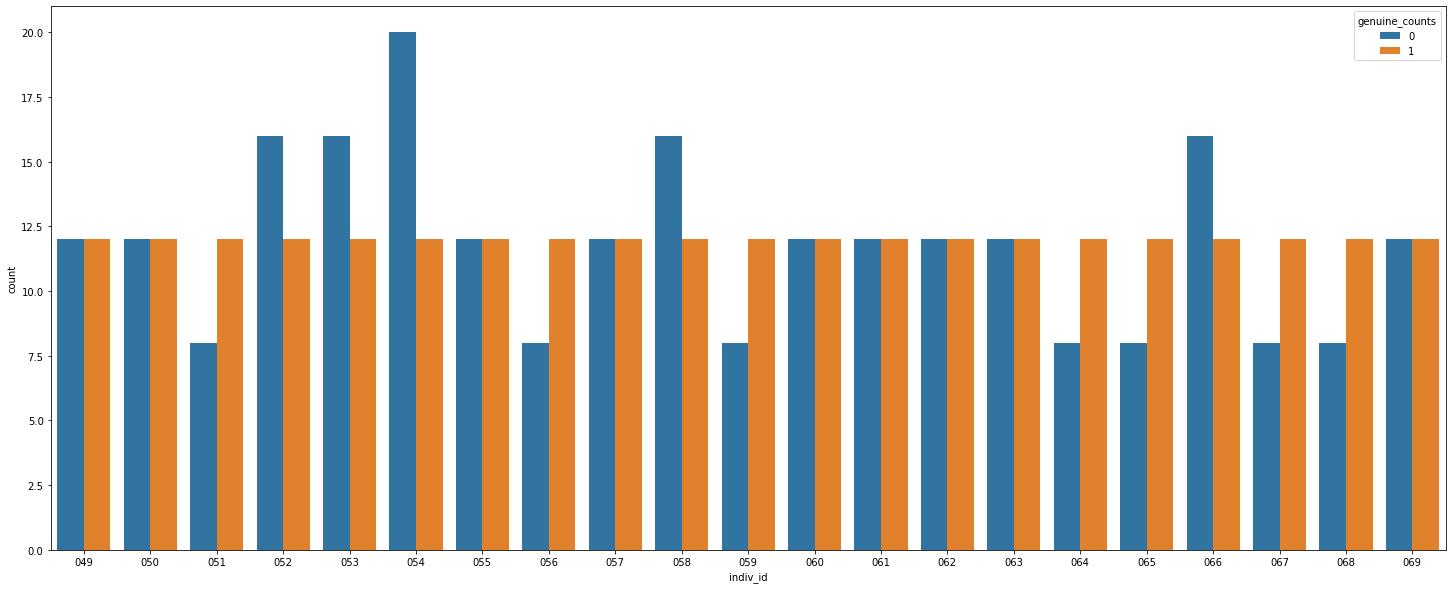

In [ ]:
plt.figure(figsize=(25,10))
ax = sns.countplot(x ="indiv_id", data = dft, hue = 'genuine_counts')



# The test directory has 21 individuals, a subset of individuals that are already in the train directory. 

#Prep for tensor flow

In [ ]:
# Prep for tensorflow 

In [ ]:
len(train_images)

1649

In [ ]:

train_labels = []
for x in train_file_name:
  p=Path(x)
  if 'forg' in x:
    new_x = re.sub('\D', '', p.parts[5])
    train_labels.append(0)
  else:
    train_labels.append(1)

In [ ]:
train_imagesofficial = []
for x in train_file_name:
  img1 = cv2.imread(x)
  train_imagesofficial.append([img1])

In [ ]:
train_imagesofficial = np.array(train_imagesofficial).astype(np.float32) / 255.0 #normalization of images1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
labels = np.array(train_labels).astype(np.float32)

In [ ]:
len(train_labels)

1649

In [ ]:
train_images = np.array(train_images).astype(np.float32) / 255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored